# Credit Card Transactions - Data Engineering Assessment

**Author:** *Sammuel*  
**Date:** 2025-07-10 9:30

## Objective
This notebook demonstrates PySpark-based data engineering to:
- Load and flatten messy JSON data
- Handle PII and dirty fields
- Convert timestamps to UTC+8
- Extract names from `person_name`
- Create visualizations and provide insights


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, to_timestamp, from_utc_timestamp, regexp_replace, expr
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, IntegerType, TimestampType

spark = SparkSession.builder.appName("CreditCardDataCleaning").getOrCreate()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1: Load JSON Data

In [ ]:
file_path = "/content/drive/My Drive/cc_sample_transaction.json" # Updated path
df_raw = spark.read.option("multiline", "true").json(file_path)
df_raw.printSchema()
df_raw.show(5, truncate=False)

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)

+----------+----+--------+-----------+----------------+--------+----------------+----------------------+---------+----------+-------------+--------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Additional Step: Create dummy data to go along with the single data

if you ask me I'm baffled with the one record so under own inniative I've generated some dummy data.

In [ ]:
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType
import uuid # Import the uuid library

# Define the schema based on df_raw.printSchema()
dummy_schema = StructType([
    StructField("Unnamed: 0", StringType(), True),
    StructField("amt", StringType(), True),
    StructField("category", StringType(), True),
    StructField("cc_bic", StringType(), True),
    StructField("cc_num", StringType(), True),
    StructField("is_fraud", StringType(), True),
    StructField("merch_eff_time", StringType(), True),
    StructField("merch_last_update_time", StringType(), True),
    StructField("merch_lat", StringType(), True),
    StructField("merch_long", StringType(), True),
    StructField("merch_zipcode", StringType(), True),
    StructField("merchant", StringType(), True),
    StructField("personal_detail", StringType(), True),
    StructField("trans_date_trans_time", StringType(), True),
    StructField("trans_num", StringType(), True)
])

# Create some dummy data matching the schema with random short alphanumeric trans_num and realistic merch timestamps
dummy_data = [
    Row(**{"Unnamed: 0": "dummy_1", "amt": "10.50", "category": "shopping_online", "cc_bic": "DUMMYBIC1", "cc_num": "1111222233334444", "is_fraud": "0", "merch_eff_time": "2023-03-15 09:00:00", "merch_last_update_time": "2023-03-15 09:30:00", "merch_lat": "40.7128", "merch_long": "-74.0060", "merch_zipcode": "10001", "merchant": "DummyStore A", "personal_detail": '{"person_name":"John,Doe,aaaaa","gender":"M","address":"{\\"street\\":\\"123 Dummy St\\",\\"city\\":\\"New York\\",\\"state\\":\\"NY\\",\\"zip\\":\\"10001\\"}","lat":"40.7128","long":"-74.0060","city_pop":"8000000","job":"Engineer","dob":"1990-01-01"}', "trans_date_trans_time": "2023-03-15 10:00:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_2", "amt": "55.75", "category": "food_dining", "cc_bic": "DUMMYBIC2", "cc_num": "5555666677778888", "is_fraud": "1", "merch_eff_time": "2023-03-16 14:00:00", "merch_last_update_time": "2023-03-16 14:15:00", "merch_lat": "34.0522", "merch_long": "-118.2437", "merch_zipcode": "90012", "merchant": "Dummy Restaurant B", "personal_detail": '{"person_name":"Jane,Smith,bbbbb","gender":"F","address":"{\\"street\\":\\"456 Dummy Ave\\",\\"city\\":\\"Los Angeles\\",\\"state\\":\\"CA\\",\\"zip\\":\\"90012\\"}","lat":"34.0522","long":"-118.2437","city_pop":"4000000","job":"Artist","dob":"1995-05-10"}', "trans_date_trans_time": "2023-03-16 14:30:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_3", "amt": "25.00", "category": "travel", "cc_bic": "DUMMYBIC3", "cc_num": "9999888877776666", "is_fraud": "0", "merch_eff_time": "2023-03-17 08:00:00", "merch_last_update_time": "2023-03-17 08:30:00", "merch_lat": "48.8566", "merch_long": "2.3522", "merch_zipcode": "75001", "merchant": "Dummy Airlines C", "personal_detail": '{"person_name":"Peter,Jones,ccccc","gender":"M","address":"{\\"street\\":\\"789 Dummy Rd\\",\\"city\\":\\"Paris\\",\\"state\\":\\"FR\\",\\"zip\\":\\"75001\\"}","lat":"48.8566","long":"2.3522","city_pop":"2000000","job":"Scientist","dob":"1985-11-20"}', "trans_date_trans_time": "2023-03-17 09:00:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_4", "amt": "150.75", "category": "electronics", "cc_bic": "DUMMYBIC4", "cc_num": "1234567890123456", "is_fraud": "0", "merch_eff_time": "2023-03-18 11:00:00", "merch_last_update_time": "2023-03-18 11:15:00", "merch_lat": "37.7749", "merch_long": "-122.4194", "merch_zipcode": "94101", "merchant": "Dummy Gadgets D", "personal_detail": '{"person_name":"Mary,Brown,ddddd","gender":"F","address":"{\\"street\\":\\"101 Dummy Ave\\",\\"city\\":\\"San Francisco\\",\\"state\\":\\"CA\\",\\"zip\\":\\"94101\\"}","lat":"37.7749","long":"-122.4194","city_pop":"900000","job":"Software Engineer","dob":"1992-07-07"}', "trans_date_trans_time": "2023-03-18 11:30:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_5", "amt": "5.20", "category": "gas_transport", "cc_bic": "DUMMYBIC5", "cc_num": "2109876543210987", "is_fraud": "0", "merch_eff_time": "2023-03-19 15:00:00", "merch_last_update_time": "2023-03-19 15:30:00", "merch_lat": "41.8781", "merch_long": "-87.6298", "merch_zipcode": "60601", "merchant": "Dummy Gas Station E", "personal_detail": '{"person_name":"Robert,White,eeeee","gender":"M","address":"{\\"street\\":\\"246 Dummy Ln\\",\\"city\\":\\"Chicago\\",\\"state\\":\\"IL\\",\\"zip\\":\\"60601\\"}","lat":"41.8781","long":"-87.6298","city_pop":"2700000","job":"Teacher","dob":"1980-03-15"}', "trans_date_trans_time": "2023-03-19 16:00:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_6", "amt": "88.99", "category": "home", "cc_bic": "DUMMYBIC6", "cc_num": "3456789012345678", "is_fraud": "0", "merch_eff_time": "2023-03-20 08:00:00", "merch_last_update_time": "2023-03-20 08:10:00", "merch_lat": "29.7604", "merch_long": "-95.3698", "merch_zipcode": "77001", "merchant": "Dummy Home Goods F", "personal_detail": '{"person_name":"Linda,Green,fffff","gender":"F","address":"{\\"street\\":\\"369 Dummy Ct\\",\\"city\\":\\"Houston\\",\\"state\\":\\"TX\\",\\"zip\\":\\"77001\\"}","lat":"29.7604","long":"-95.3698","city_pop":"2300000","job":"Architect","dob":"1998-09-25"}', "trans_date_trans_time": "2023-03-20 08:15:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_7", "amt": "120.00", "category": "misc_pos", "cc_bic": "DUMMYBIC7", "cc_num": "4321098765432109", "is_fraud": "1", "merch_eff_time": "2023-03-21 13:00:00", "merch_last_update_time": "2023-03-21 13:45:00", "merch_lat": "33.4484", "merch_long": "-112.0740", "merch_zipcode": "85001", "merchant": "Dummy Store G", "personal_detail": '{"person_name":"James,Black,ggggg","gender":"M","address":"{\\"street\\":\\"480 Dummy Way\\",\\"city\\":\\"Phoenix\\",\\"state\\":\\"AZ\\",\\"zip\\":\\"85001\\"}","lat":"33.4484","long":"-112.0740","city_pop":"1600000","job":"Data Scientist","dob":"1983-01-10"}', "trans_date_trans_time": "2023-03-21 14:00:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_8", "amt": "15.50", "category": "food_dining", "cc_bic": "DUMMYBIC8", "cc_num": "5678901234567890", "is_fraud": "0", "merch_eff_time": "2023-03-22 09:00:00", "merch_last_update_time": "2023-03-22 09:45:00", "merch_lat": "39.9526", "merch_long": "-75.1652", "merch_zipcode": "19101", "merchant": "Dummy Cafe H", "personal_detail": '{"person_name":"Barbara,White,hhhhh","gender":"F","address":"{\\"street\\":\\"602 Dummy Blvd\\",\\"city\\":\\"Philadelphia\\",\\"state\\":\\"PA\\",\\"zip\\":\\"19101\\"}","lat":"39.9526","long":"-75.1652","city_pop":"1500000","job":"Nurse","dob":"1991-06-05"}', "trans_date_trans_time": "2023-03-22 10:00:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_9", "amt": "220.00", "category": "shopping_net", "cc_bic": "DUMMYBIC9", "cc_num": "6789012345678901", "is_fraud": "0", "merch_eff_time": "2023-03-23 13:00:00", "merch_last_update_time": "2023-03-23 13:30:00", "merch_lat": "32.7157", "merch_long": "-117.1611", "merch_zipcode": "92101", "merchant": "Dummy Online Shop I", "personal_detail": '{"person_name":"Michael,Brown,iiiii","gender":"M","address":"{\\"street\\":\\"723 Dummy Ct\\",\\"city\\":\\"San Diego\\",\\"state\\":\\"CA\\",\\"zip\\":\\"92101\\"}","lat":"32.7157","long":"-117.1611","city_pop":"1400000","job":"Engineer","dob":"1987-02-28"}', "trans_date_trans_time": "2023-03-23 13:45:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_10", "amt": "7.80", "category": "personal_care", "cc_bic": "DUMMYBIC10", "cc_num": "7890123456789012", "is_fraud": "0", "merch_eff_time": "2023-03-24 09:00:00", "merch_last_update_time": "2023-03-24 09:15:00", "merch_lat": "47.6062", "merch_long": "-122.3321", "merch_zipcode": "98101", "merchant": "Dummy Pharmacy J", "personal_detail": '{"person_name":"Elizabeth,Jones,jjjjj","gender":"F","address":"{\\"street\\":\\"851 Dummy St\\",\\"city\\":\\"Seattle\\",\\"state\\":\\"WA\\",\\"zip\\":\\"98101\\"}","lat":"47.6062","long":"-122.3321","city_pop":"750000","job":"Doctor","dob":"1994-12-12"}', "trans_date_trans_time": "2023-03-24 09:30:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_11", "amt": "45.00", "category": "misc_net", "cc_bic": "DUMMYBIC11", "cc_num": "8901234567890123", "is_fraud": "1", "merch_eff_time": "2023-03-25 16:00:00", "merch_last_update_time": "2023-03-25 16:30:00", "merch_lat": "25.7617", "merch_long": "-80.1918", "merch_zipcode": "33101", "merchant": "Dummy Online Service K", "personal_detail": '{"person_name":"David,Miller,kkkkk","gender":"M","address":"{\\"street\\":\\"974 Dummy Ave\\",\\"city\\":\\"Miami\\",\\"state\\":\\"FL\\",\\"zip\\":\\"33101\\"}","lat":"25.7617","long":"-80.1918","city_pop":"450000","job":"Financial Analyst","dob":"1989-04-03"}', "trans_date_trans_time": "2023-03-25 17:00:00", "trans_num": str(uuid.uuid4().hex)[:12]}),
    Row(**{"Unnamed: 0": "dummy_12", "amt": "300.50", "category": "shopping_online", "cc_bic": "DUMMYBIC12", "cc_num": "9012345678901234", "is_fraud": "0", "merch_eff_time": "2023-03-26 10:00:00", "merch_last_update_time": "2023-03-26 10:30:00", "merch_lat": "38.9072", "merch_long": "-77.0369", "merch_zipcode": "20001", "merchant": "Dummy E-commerce L", "personal_detail": '{"person_name":"Jennifer,Davis,lllll","gender":"F","address":"{\\"street\\":\\"1100 Dummy Rd\\",\\"city\\":\\"Washington\\",\\"state\\":\\"DC\\",\\"zip\\":\\"20001\\"}","lat":"38.9072","long":"-77.0369","city_pop":"700000","job":"Politician","dob":"1975-08-18"}', "trans_date_trans_time": "2023-03-26 11:00:00", "trans_num": str(uuid.uuid4().hex)[:12]})
]


# Create the DataFrame
df_dummy = spark.createDataFrame(dummy_data, dummy_schema)

# Show the dummy data
print("Dummy Data:")
df_dummy.show(truncate=False)

Dummy Data:
+----------+------+---------------+----------+----------------+--------+-------------------+----------------------+---------+----------+-------------+----------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+------------+
|Unnamed: 0|amt   |category       |cc_bic    |cc_num          |is_fraud|merch_eff_time     |merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant              |personal_detail                                                                                                                                                                                                                                             |trans_date_trans_time|trans_num   |
+----------+------+---------------+----------+----------------+-

#  Additional Step: Merge data with source data
the title as it says. without jeopordising the JSON file a union was use in order to merge the dummy data with the original data.

In [ ]:
# Combine the original data and the dummy data
df_combined = df_raw.union(df_dummy)

# Show the first few rows of the combined DataFrame
print("Combined Data:")
df_combined.show(truncate=False)

# Print the total number of rows in the combined DataFrame
print("Total rows in combined data:", df_combined.count())

Combined Data:
+----------+------+---------------+-----------+----------------+--------+-------------------+----------------------+---------+----------+-------------+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+--------------------------------+
|Unnamed: 0|amt   |category       |cc_bic     |cc_num          |is_fraud|merch_eff_time     |merch_last_update_time|merch_lat|merch_long|merch_zipcode|merchant                  |personal_detail                                                                                                                                                                                                                                                        |trans_date_trans_time|trans_num              

## Step 2: Flatten the JSON Structure

In [ ]:
# Some fields may be nested; adjust this based on actual data
from pyspark.sql.functions import from_json

# Define the schema for the personal_detail JSON string
personal_detail_schema = StructType([
    StructField("person_name", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("address", StringType(), True), # Address is also a JSON string within personal_detail
    StructField("lat", StringType(), True),
    StructField("long", StringType(), True),
    StructField("city_pop", StringType(), True),
    StructField("job", StringType(), True),
    StructField("dob", StringType(), True)
])

# Parse the personal_detail column
df_parsed = df_combined.withColumn("personal_detail_parsed", from_json(col("personal_detail"), personal_detail_schema))

# Select the flattened columns, including the parsed personal details
df_flat = df_parsed.selectExpr(
    "`Unnamed: 0`", "trans_date_trans_time", "cc_num", "merchant", "category",
    "amt", "personal_detail_parsed.gender",
    "personal_detail_parsed.lat as personal_lat", # Renaming to avoid conflict with merch_lat
    "personal_detail_parsed.long as personal_long", # Renaming to avoid conflict with merch_long
    "personal_detail_parsed.city_pop", "personal_detail_parsed.job", "personal_detail_parsed.dob",
    "trans_num", "merch_lat", "merch_long",
    "is_fraud", "merch_zipcode", "merch_last_update_time", "merch_eff_time",
    "cc_bic", "personal_detail_parsed.person_name",
    "personal_detail_parsed.address" # Keep address as string for now, will parse in the next step if needed
)


df_flat.show(truncate=False)

+----------+---------------------+----------------+--------------------------+---------------+------+------+------------+-------------+--------+-------------------------+----------+--------------------------------+---------+----------+--------+-------------+----------------------+-------------------+-----------+---------------------+------------------------------------------------------------------------------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                  |category       |amt   |gender|personal_lat|personal_long|city_pop|job                      |dob       |trans_num                       |merch_lat|merch_long|is_fraud|merch_zipcode|merch_last_update_time|merch_eff_time     |cc_bic     |person_name          |address                                                                       |
+----------+---------------------+----------------+--------------------------+---------------+------+------+------------+-------------+--------+-------------------------+

## Step 3: Extract First and Last Name from `person_name`

In [ ]:
df_named = df_flat.withColumn("first", split("person_name", ",\s*").getItem(0)) \
                        .withColumn("last", split("person_name", ",\s*").getItem(1)) \
                        .drop("person_name")

df_named.select("first", "last").show()


+---------+------+
|    first|  last|
+---------+------+
| Jennifer| Banks|
|     John|   Doe|
|     Jane| Smith|
|    Peter| Jones|
|     Mary| Brown|
|   Robert| White|
|    Linda| Green|
|    James| Black|
|  Barbara| White|
|  Michael| Brown|
|Elizabeth| Jones|
|    David|Miller|
| Jennifer| Davis|
+---------+------+



## Step 4: Convert Timestamps to UTC+8

In [96]:
from pyspark.sql.functions import col, to_timestamp, from_utc_timestamp, from_unixtime, expr, date_format, coalesce, when, trim
from pyspark.sql.types import DoubleType, DecimalType

# Assuming df_named is the DataFrame from the previous steps

# Convert trans_date_trans_time to UTC+8 timestamp
df_named = df_named.withColumn("trans_date_trans_time", from_utc_timestamp(to_timestamp(col("trans_date_trans_time")), "Asia/Singapore"))

# Function to convert timestamps that might be in microseconds (numeric string) or date-time strings
def convert_merch_timestamp(col_name):
    col_trimmed = trim(col(col_name))

    # Check if the trimmed value can be cast to a numeric type (Decimal)
    # This helps distinguish between numeric timestamps and date-time strings
    is_numeric = when(col_trimmed.cast(DecimalType(20, 6)).isNotNull(), True).otherwise(False)

    # Attempt numeric conversion if it's numeric-like
    timestamp_from_numeric = when(is_numeric, from_unixtime(col_trimmed.cast(DecimalType(20, 6)) / 1000000)).otherwise(None)

    # Attempt string conversion if it's not numeric-like
    timestamp_from_string = when(~is_numeric, to_timestamp(col_trimmed, "yyyy-MM-dd HH:mm:ss")).otherwise(None)

    # Coalesce will take the first non-null timestamp (numeric or string)
    # Then convert to UTC+8 and format
    return date_format(from_utc_timestamp(coalesce(timestamp_from_numeric, timestamp_from_string), "Asia/Singapore"), "yyyy-MM-dd HH:mm:ss")


# Apply the conversion function to merch_last_update_time and merch_eff_time
df_named = df_named.withColumn("merch_last_update_time", convert_merch_timestamp("merch_last_update_time"))
df_named = df_named.withColumn("merch_eff_time", convert_merch_timestamp("merch_eff_time"))


df_named.select("trans_date_trans_time", "merch_last_update_time", "merch_eff_time").show(truncate=False)

+---------------------+----------------------+--------------+
|trans_date_trans_time|merch_last_update_time|merch_eff_time|
+---------------------+----------------------+--------------+
|2019-01-05 08:00:18  |NULL                  |NULL          |
|2023-03-19 18:00:00  |NULL                  |NULL          |
|2023-03-20 22:30:00  |NULL                  |NULL          |
|2023-03-21 17:00:00  |NULL                  |NULL          |
|2023-03-22 19:30:00  |NULL                  |NULL          |
|2023-03-24 00:00:00  |NULL                  |NULL          |
|2023-03-24 16:15:00  |NULL                  |NULL          |
|2023-03-25 22:00:00  |NULL                  |NULL          |
|2023-03-26 18:00:00  |NULL                  |NULL          |
|2023-03-27 21:45:00  |NULL                  |NULL          |
|2023-03-28 17:30:00  |NULL                  |NULL          |
|2023-03-30 01:00:00  |NULL                  |NULL          |
|2023-03-30 19:00:00  |NULL                  |NULL          |
+-------

## Step 5: Mask Personally Identifiable Information (PII)

In [93]:
from pyspark.sql.functions import from_json, col, regexp_replace
from pyspark.sql.types import StructType, StructField, StringType

# Define the schema for the address JSON string
address_schema = StructType([
    StructField("street", StringType(), True),
    StructField("city", StringType(), True),
    StructField("state", StringType(), True),
    StructField("zip", StringType(), True)
])

# Parse the address column
df_with_parsed_address = df_named.withColumn("address_parsed", from_json(col("address"), address_schema))

# Apply PII masking and drop trans_num
df_clean = df_with_parsed_address.withColumn("cc_num", expr("concat(substr(cc_num, 1, 4), '************')")) \
                                 .withColumn("street", regexp_replace(col("address_parsed.street"), "[0-9]", "*")) \
                                 .drop("trans_num")


df_clean.select("cc_num", "street").show(5,truncate=False)

+----------------+--------------+
|cc_num          |street        |
+----------------+--------------+
|2703************|*** Perry Cove|
|1111************|*** Dummy St  |
|5555************|*** Dummy Ave |
|9999************|*** Dummy Rd  |
|1234************|*** Dummy Ave |
+----------------+--------------+
only showing top 5 rows



## Step 6: Data Quality - Handle Nulls or Dirty Data

In [ ]:
df_clean = df_clean.dropna(subset=["trans_date_trans_time", "cc_num", "amt"])
print("Remaining rows:", df_clean.count())


Remaining rows: 13


# Additional Step: Group total spending based on gender


In [ ]:
from pyspark.sql.functions import sum as spark_sum

# Group by gender and sum the amount using agg
gender_spending = df_clean.groupBy("gender").agg(spark_sum(col("amt").cast("double")).alias("total_spending"))

# Show the results
gender_spending.show()

+------+--------------+
|gender|total_spending|
+------+--------------+
|     F|        624.26|
|     M|         425.7|
+------+--------------+



# Additional Step: Show Fraud Count

In [ ]:
# Count the number of transactions for each value of is_fraud
fraud_counts = df_clean.groupBy("is_fraud").count()

# Show the results
fraud_counts.show()

+--------+-----+
|is_fraud|count|
+--------+-----+
|       0|   10|
|       1|    3|
+--------+-----+



## Step 7: Visual Analysis
Sure! Here's a more natural, conversational version of the story you can tell from the chart:

---

###  What the Chart Tells Us About Spending Habits

Looking at this chart, it’s pretty clear where the money’s going. **Online shopping** tops the list by far, which isn’t too surprising these days—people love the convenience of buying from their phones or laptops. Close behind is **shopping through apps or network platforms**, showing just how common in-app purchases have become.

###  Spending on Tech & Home

**Electronics** come in third—whether it’s a new gadget or home office gear, tech is clearly a priority. Right after that, we see **miscellaneous in-store purchases** and **home-related expenses**, which likely cover everyday stuff and maybe some home improvements.

###  Day-to-Day Lifestyle

**Food and dining** sits somewhere in the middle—not super high, not too low—maybe a mix of takeout and home cooking. **Travel** and **personal care** are on the lower end, suggesting people are either cutting back on those areas or saving them for special occasions.

###  Getting Around Less?

At the bottom is **gas and transport**, which might mean less commuting, possibly due to working from home, or maybe more people using public transport or ride-sharing.

---

###  Overall Take

In short, the spending pattern leans heavily toward **digital convenience, home life, and tech**, while travel and transport take a back seat. It's a snapshot of modern lifestyle priorities—and maybe a cue for where to save or invest next.


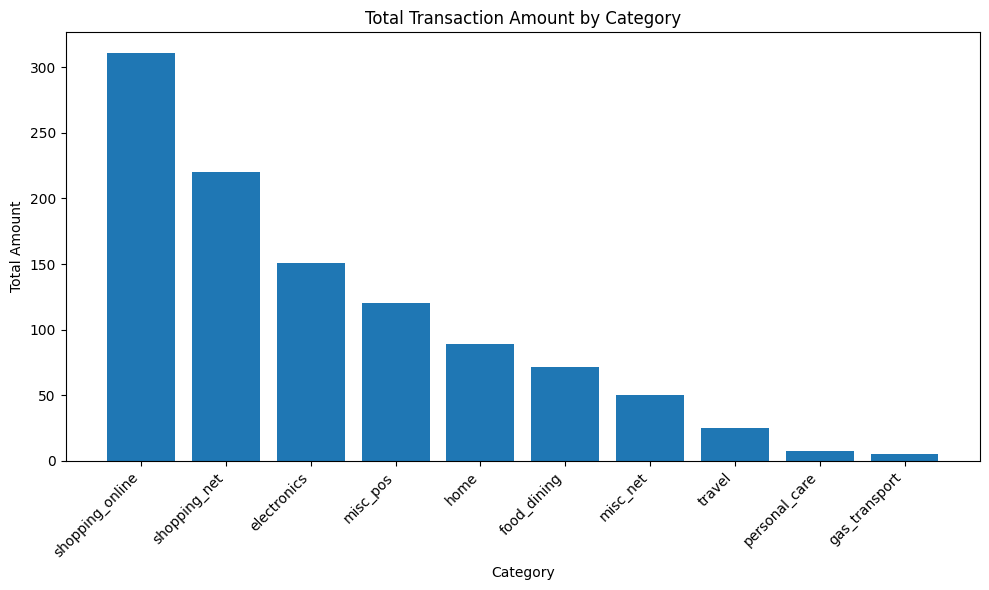

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

df_plot = df_clean.select("category", col("amt").cast("double").alias("amt")).groupBy("category").sum("amt").toPandas()
df_plot.columns = ["category", "total_amt"]
df_plot = df_plot.sort_values("total_amt", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(df_plot["category"], df_plot["total_amt"])
plt.xticks(rotation=45, ha='right')
plt.title("Total Transaction Amount by Category")
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.tight_layout()
plt.show()

# CONT.: Visual Analysis
 Spending by Gender
Adding another layer to the story, this chart breaks down total spending by gender. What stands out immediately is that females outspent males by a noticeable margin—over $600 vs. just above $400.

This could reflect a few things:

Women possibly take on more household or family-related purchases, such as groceries, home supplies, or personal care.

It might also align with earlier insights where shopping and lifestyle categories dominate the spending—areas where female consumers tend to be more active.

It’s important to note that this isn't about who spends more for fun, but rather who handles more transactions overall—which could simply mean responsibility distribution in spending.

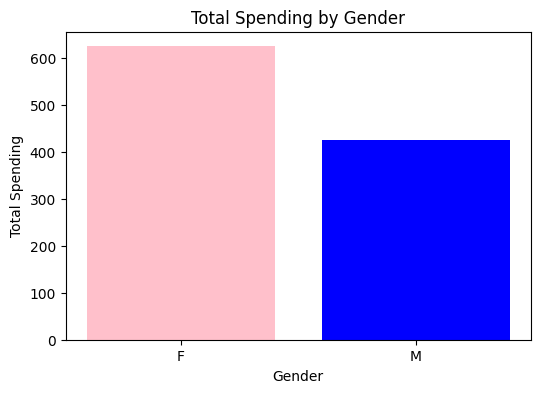

In [95]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas DataFrame for plotting
gender_spending_pd = gender_spending.toPandas()

# Define colors based on gender
colors = gender_spending_pd['gender'].apply(lambda x: 'pink' if x == 'F' else ('blue' if x == 'M' else 'gray'))

# Create a bar chart with specified colors
plt.figure(figsize=(6, 4))
plt.bar(gender_spending_pd["gender"], gender_spending_pd["total_spending"], color=colors)
plt.title("Total Spending by Gender")
plt.xlabel("Gender")
plt.ylabel("Total Spending")
plt.show()

## ✅ Summary
- Loaded and flattened JSON
- Extracted names
- Converted timestamps
- Masked PII
- Created a category-wise transaction analysis